In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [34]:
import re
import string
from tqdm import tqdm
import os

from gensim.parsing.preprocessing import remove_stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import OrderedDict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import classification_report,f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

import torch
import transformers

In [35]:
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

In [3]:
train = pd.read_csv('../../data/nlp_tweet_data/train.csv')
train.shape

(7613, 5)

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test = pd.read_csv('../../data/nlp_tweet_data/test.csv')
test.shape

(3263, 4)

In [6]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
train['location'].value_counts()

USA                            104
New York                        71
United States                   50
London                          45
Canada                          29
                              ... 
Rafael castillo                  1
statesboro/vidalia               1
Greenpoint                       1
Proudly frozen Canuck eh !!      1
Milton Keynes                    1
Name: location, Length: 3341, dtype: int64

In [9]:
train['keyword'].value_counts()

fatalities               45
armageddon               42
deluge                   42
damage                   41
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

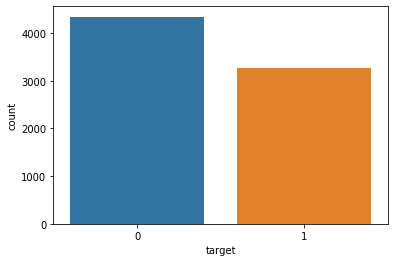

In [10]:
sns.countplot(x='target', data=train)

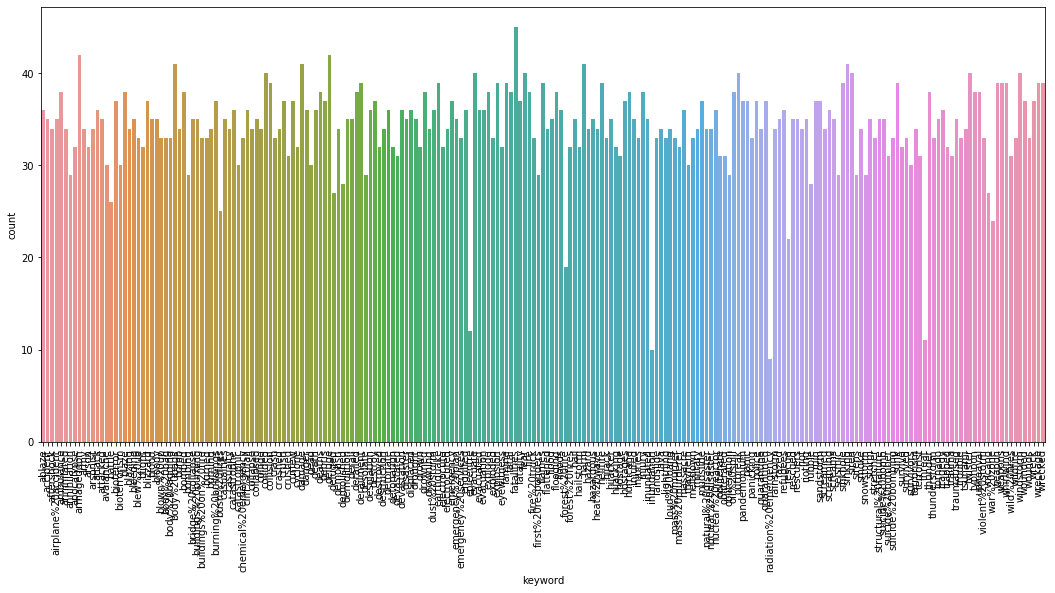

In [11]:
plt.figure(figsize=(18,8))
plt.xticks(rotation=90)
ax = sns.countplot(x='keyword', data=train)

In [12]:
#removing any shortforms if present
def remove_shortforms(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def remove_special_char(text):
    text = re.sub('[^A-Za-z0-9]+'," ",text)
    return text

def remove_wordswithnum(text):
    text = re.sub("\S*\d\S*", "", text).strip()
    return text

def lowercase(text):
    text = text.lower()
    return text

def remove_stop_words(text):
    text = remove_stopwords(text)
    return text

st = SnowballStemmer(language='english')
def stemming(text):
    r= []
    for word in text :
        a = st.stem(word)
        r.append(a)
    return r

def listToString(s):  
    str1 = " "   
    return (str1.join(s))

def remove_punctuations(text):
    text = re.sub(r'[^\w\s]','',text)
    return text

def remove_links(text):
    text = re.sub(r'http\S+', '', text)
    return text

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    text = lemmatizer.lemmatize(text)
    return text

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [13]:
Y = train['target']
train = train.drop('target',axis=1)
data = pd.concat([train,test],axis=0).reset_index(drop=True)
data.head()

,id,keyword,location,text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...


In [14]:
# Here i am converting all the text sentences into str just to make sure my code does not get stuck at any point later on.

for i in range(len(data['text'])):
    data['text'][i] = str(data['text'][i])

/Users/nehapawar/Desktop/neha/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [15]:
data['text'][1]


'Forest fire near La Ronge Sask. Canada'

In [16]:
for i in range(len(data['text'])):
    data['text'][i] = remove_shortforms(data['text'][i])
    data['text'][i] = remove_special_char(data['text'][i])
    data['text'][i] = remove_wordswithnum(data['text'][i])
    data['text'][i] = lowercase(data['text'][i])
    data['text'][i] = remove_stop_words(data['text'][i])
    text = data['text'][i]
    text = text.split()
    data['text'][i] = stemming(text)
    s = data['text'][i]
    data['text'][i] = listToString(s)
    data['text'][i] = lemmatize_words(data['text'][i])

/Users/nehapawar/Desktop/neha/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/nehapawar/Desktop/neha/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/nehapawar/Desktop/neha/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [18]:
data['text'][1]


'forest near la rong sask canada'

ML takes input in the form of numbers not in text. So we need to convert this text into numbers:

     - Tokenization
     - Word indexing

## Word to vectors

In [21]:
# Limit on the number of features to K features.
TOP_K = 20000

# Limit on the length of text sequences. 
# Sequences longer than this will be truncated.
# and less than it will be padded
MAX_SEQUENCE_LENGTH = 50

class CustomTokenizer:
    def __init__(self, train_texts):
        self.train_texts = train_texts
        self.tokenizer = Tokenizer(num_words=TOP_K)
        
    def train_tokenize(self):
        # Get max sequence length.
        max_length = len(max(self.train_texts , key=len))
        self.max_length = min(max_length, MAX_SEQUENCE_LENGTH)
    
        # Create vocabulary with training texts.
        self.tokenizer.fit_on_texts(self.train_texts)
        
    def vectorize_input(self, tweets):
        # Vectorize training and validation texts.
        
        tweets = self.tokenizer.texts_to_sequences(tweets)
        # Fix sequence length to max value. Sequences shorter than the length are
        # padded in the beginning and sequences longer are truncated
        # at the beginning.
        tweets = sequence.pad_sequences(tweets, maxlen=self.max_length, truncating='post',padding='post')
        return tweets

In [22]:
tokenizer = CustomTokenizer(train_texts = data['text'])
# fit o the train
tokenizer.train_tokenize()
tokenized_train = tokenizer.vectorize_input(data['text'])


## Create embedding matrix

In [24]:
import tqdm

EMBEDDING_VECTOR_LENGTH = 50 # <=200
def construct_embedding_matrix(glove_file, word_index):
    embedding_dict = {}
    with open(glove_file,'r') as f:
        for line in f:
            values=line.split()
            # get the word
            word=values[0]
            if word in word_index.keys():
                # get the vector
                vector = np.asarray(values[1:], 'float32')
                embedding_dict[word] = vector
    ###  oov words (out of vacabulary words) will be mapped to 0 vectors

    num_words=len(word_index)+1
    #initialize it to 0
    embedding_matrix=np.zeros((num_words, EMBEDDING_VECTOR_LENGTH))

    for word,i in tqdm.tqdm(word_index.items()):
        if i < num_words:
            vect=embedding_dict.get(word, [])
            if len(vect)>0:
                embedding_matrix[i] = vect[:EMBEDDING_VECTOR_LENGTH]
    return embedding_matrix
  
embedding_matrix =  construct_embedding_matrix('extra_data/glove.6B.100d.txt', tokenizer.tokenizer.word_index)


100%|██████████| 16812/16812 [00:00<00:00, 829115.78it/s]


## Create and Train Model

In [27]:
train_pad = tokenized_train[:train.shape[0]]
test_pad = tokenized_train[train.shape[0]:]

In [28]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [39]:
model1 = keras.models.Sequential([
    keras.layers.Embedding(len(tokenizer.tokenizer.word_index)+1, # number of unique tokens
                    EMBEDDING_VECTOR_LENGTH, #number of features
                    embeddings_initializer=Constant(embedding_matrix), # initialize 
                    input_length=MAX_SEQUENCE_LENGTH, 
                    trainable=False),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.5),
    keras.layers.Dense(1,activation='sigmoid')
])

In [42]:
model1.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy'],
)

In [43]:
history1 = model1.fit(train_pad,Y,
                    batch_size=64,
                    epochs=10,
                    validation_split=0.2
)

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 6s 922us/sample - loss: 0.6642 - accuracy: 0.6103 - val_loss: 0.5776 - val_accuracy: 0.7538
Epoch 2/10
6090/6090 [==============================] - 4s 593us/sample - loss: 0.6296 - accuracy: 0.6663 - val_loss: 0.5586 - val_accuracy: 0.7643
Epoch 3/10
6090/6090 [==============================] - 4s 597us/sample - loss: 0.6317 - accuracy: 0.6698 - val_loss: 0.5789 - val_accuracy: 0.7380
Epoch 4/10
6090/6090 [==============================] - 4s 589us/sample - loss: 0.6240 - accuracy: 0.6846 - val_loss: 0.6124 - val_accuracy: 0.6875
Epoch 5/10
6090/6090 [==============================] - 4s 588us/sample - loss: 0.6391 - accuracy: 0.6576 - val_loss: 0.5721 - val_accuracy: 0.7308
Epoch 6/10
6090/6090 [==============================] - 4s 590us/sample - loss: 0.6254 - accuracy: 0.6814 - val_loss: 0.5705 - val_accuracy: 0.7518
Epoch 7/10
6090/6090 [==============================] - 4s 588us

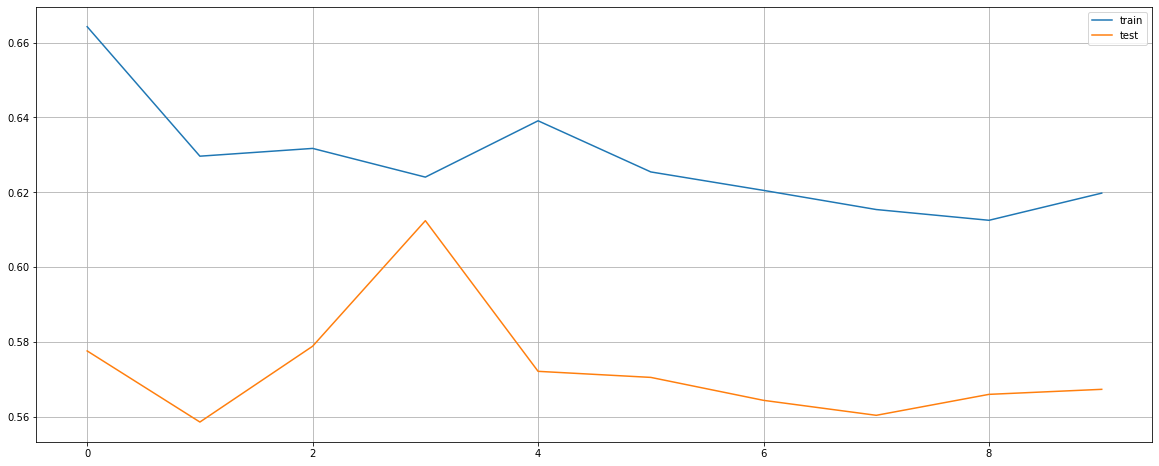

In [44]:
plt.figure(figsize=(20,8))
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='test')
plt.legend()
plt.grid()
plt.show()

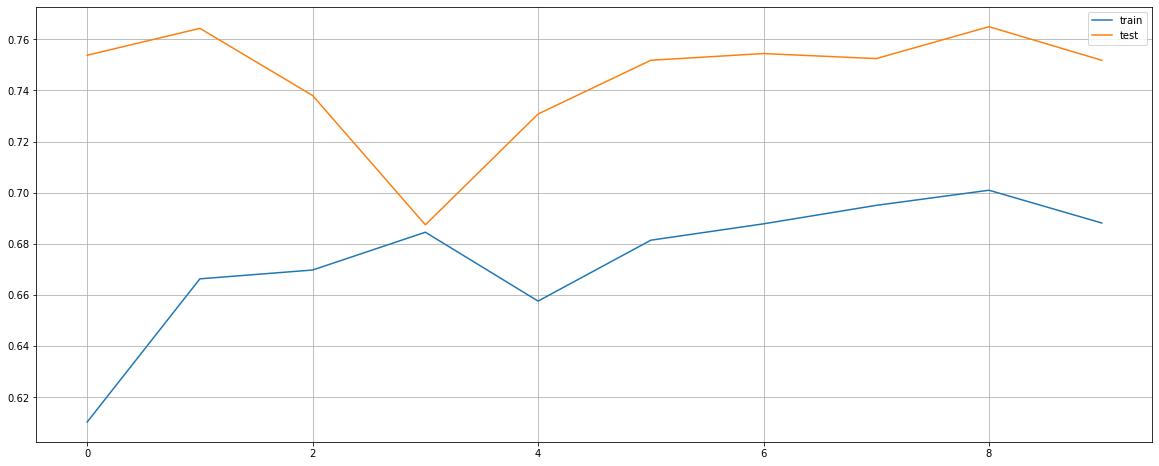

In [45]:
plt.figure(figsize=(20,8))
plt.plot(history1.history['accuracy'], label='train')
plt.plot(history1.history['val_accuracy'], label='test')
plt.legend()
plt.grid()
plt.show()

## Submit Predictions

In [46]:
submit = pd.DataFrame(test['id'],columns=['id'])
predictions = model1.predict(test_pad)
submit['target_prob'] = predictions
submit.head()

,id,target_prob
0,0,0.306701
1,2,0.306701
2,3,0.698694
3,9,0.306747
4,11,0.698646


In [47]:
target = [None]*len(submit)
for i in range(len(submit)):
    target[i] = np.round(submit['target_prob'][i]).astype(int)
submit['target'] = target
submit.head()

,id,target_prob,target
0,0,0.306701,0
1,2,0.306701,0
2,3,0.698694,1
3,9,0.306747,0
4,11,0.698646,1


In [48]:
submit = submit.drop('target_prob',axis=1)
submit.to_csv('../../kaggle_out_data/disaster_tweets_lstm.csv',index=False)

In [19]:
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('extra_data/glove.6B.200d.txt'), encoding = "utf-8") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split() #split at space
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32') #numpy.asarray()function is used when we want to convert input to an array.
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [20]:
data['text'][1]

'forest near la rong sask canada'